## AI Text Summarization

#### Data Description
The **CNN/Daily Mail dataset** is a popular benchmark for text summarization. It consists of news articles from CNN and the Daily Mail newspapers paired with human-written summaries (called highlights). Researchers commonly use this dataset to train and evaluate summarization models, as it provides a large collection of real-world articles and reference summaries. In total, the dataset has over 300,000 article-summary pairs (about 287k for training, 13k for validation, 11k for test). Each article is a news story (multiple paragraphs long), and the corresponding highlights are a few sentences giving a brief summary of the article’s main points.

For this project, the dataset is provided in three CSV files (train.csv, validation.csv, test.csv). We downloaded the data from kaggle using the kaggle API and stored it under a data/ folder. Each file has three columns: id, article, and highlights. The article is the full news text, and highlights is the summary.

In [43]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from collections import Counter

# Apply tqdm to all .apply() functions by using progress_apply
tqdm.pandas()

In [44]:
# Load the dataset
train_df = pd.read_csv('../data/cnn_dailymail/train.csv')
val_df   = pd.read_csv('../data/cnn_dailymail/validation.csv')
test_df  = pd.read_csv('../data/cnn_dailymail/test.csv')

print("Training samples:", len(train_df))
train_df.head(5)

Training samples: 287113


,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [45]:
# Show a sample article and its highlights (summary)
sample = train_df.iloc[96]
print("Article ID:", sample['id'])
print("Article text (truncated):", sample['article'][:300], "...")
print("\nReference Summary:", sample['highlights'])

Article ID: 004f0f8c694c4b546b29565a8993a555537ff561
Article text (truncated): PUBLISHED: . 07:04 EST, 9 January 2014 . | . UPDATED: . 07:16 EST, 9 January 2014 . A woman whose nose and upper lip were bitten off by mice when she was a baby is to receive free plastic surgery. Zhu Sanni, 23, from Qingdao, Shandong Province, had been left alone at home for three days when the ani ...

Reference Summary: Zhu Sanni, 23, had been left alone at home for three days when it happened .
Her father suffered from a mental illness and often left home .
Mother went out for food and did not return for three days .


In the above example, the article (truncated for display) is a CNN news story, and the highlights consist of several key points from the story. The highlights are written in a few sentences in new lines. This illustrates the typical input-output pair for our summarization task: input is a long news article, output is a short summary capturing the article’s main facts.

#### Data Cleaning

Real-world text data often requires cleaning before modeling. We will perform the following cleaning steps:
- Handling Missing Values: First, check if any articles or highlights are missing (null). If so, those rows would be removed because a summarization pair with a missing text or summary is not usable.
- Outlier Detection: Check for any extremely short or long articles/summaries that might be anomalies (for example, an article with only one sentence, or a summary that is uncharacteristically long). We might handle these on a case-by-case basis (perhaps exclude if they seem like data errors).
- Text Preprocessing: Clean the text by standardizing case and removing unwanted characters:
    - Convert text to lowercase (for models that are not case-sensitive, like a custom LSTM, to reduce vocabulary size).
    - Remove or normalize special characters, digits, or extraneous symbols that don’t contribute meaning. For instance, the CNN articles often start with location strings like “(CNN) – “, which we can remove because they are not useful for summarization. We also remove any lingering HTML entities or odd punctuation.
    - Fix spacing issues (remove extra whitespaces or newline characters within the article text). In many cases, the highlights in this dataset are separated by newline characters in the raw data; we might want to join them into a single summary string (the CSV may have already done this by putting all bullet points into one text).

In [46]:
# Missing value check
print("Missing in articles:", train_df['article'].isnull().sum())
print("Missing in highlights:", train_df['highlights'].isnull().sum())

Missing in articles: 0
Missing in highlights: 0


In [52]:
# Function to remove prefixes from the article text
def clean_prefix(text):
    # Remove news source prefixes (with or without location)
    # This pattern matches an optional location (letters, spaces, commas)
    # followed by a parenthesized news source.
    text = re.sub(r'^(?:[\w\s,]+)?\s*\(\s*[A-Za-z. ]+\s*\)\s*', '', text)
    
    # Remove full publication info starting with "By . Associated Press" followed by publication details.
    # The non-greedy ".*?" will catch everything until the final period of the prefix.
    text = re.sub(r'^By\s*\.\s*Associated\s+Press\s*\..*?UPDATED:\s*\..*?\.\s*', '', text, flags=re.DOTALL)
    
    # Remove publication info starting directly with "PUBLISHED:"
    text = re.sub(r'^PUBLISHED:\s*\..*?UPDATED:\s*\..*?\.\s*', '', text, flags=re.DOTALL)

    # Normalize whitespace
    text = ' '.join(text.split())
    
    return text

# Apply cleaning to articles
train_df['article'] = train_df['article'].progress_apply(lambda x: clean_prefix(str(x)))

100%|██████████| 287113/287113 [00:11<00:00, 24981.78it/s]


In [53]:
# Verify the removal of prefixes
sample = train_df.iloc[96]
print("Article text (truncated):", sample['article'][:300], "...")

Article text (truncated): A woman whose nose and upper lip were bitten off by mice when she was a baby is to receive free plastic surgery. Zhu Sanni, 23, from Qingdao, Shandong Province, had been left alone at home for three days when the animals began to eat her face. Her father suffered from a mental illness and often left ...


In [54]:
# Function to clean text
def clean_text(text):
    # Remove HTML tags (anything between < and >)
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove URLs (matches http://, https://, or www.)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove newline characters (replace them with a space)
    text = re.sub(r'\n+', ' ', text)
    
    # Remove extra spaces: replace any sequence of whitespace with a single space and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning to articles
train_df['article'] = train_df['article'].progress_apply(lambda x: clean_text(str(x)))

100%|██████████| 287113/287113 [00:47<00:00, 6007.38it/s]


#### Data Exploration
Before building models, it’s important to explore the dataset to understand its characteristics. We will look at statistics like the length of articles vs. summaries, and visualize their distributions. This will inform decisions like truncating long articles for modeling or setting max sequence lengths.

100%|██████████| 287113/287113 [00:00<00:00, 485226.77it/s]


Avg article length (words): 691.8694938926485
Avg summary length (words): 51.574101486174435
Max article length: 2347
Max summary length: 1296
Min article length: 8
Min summary length: 4


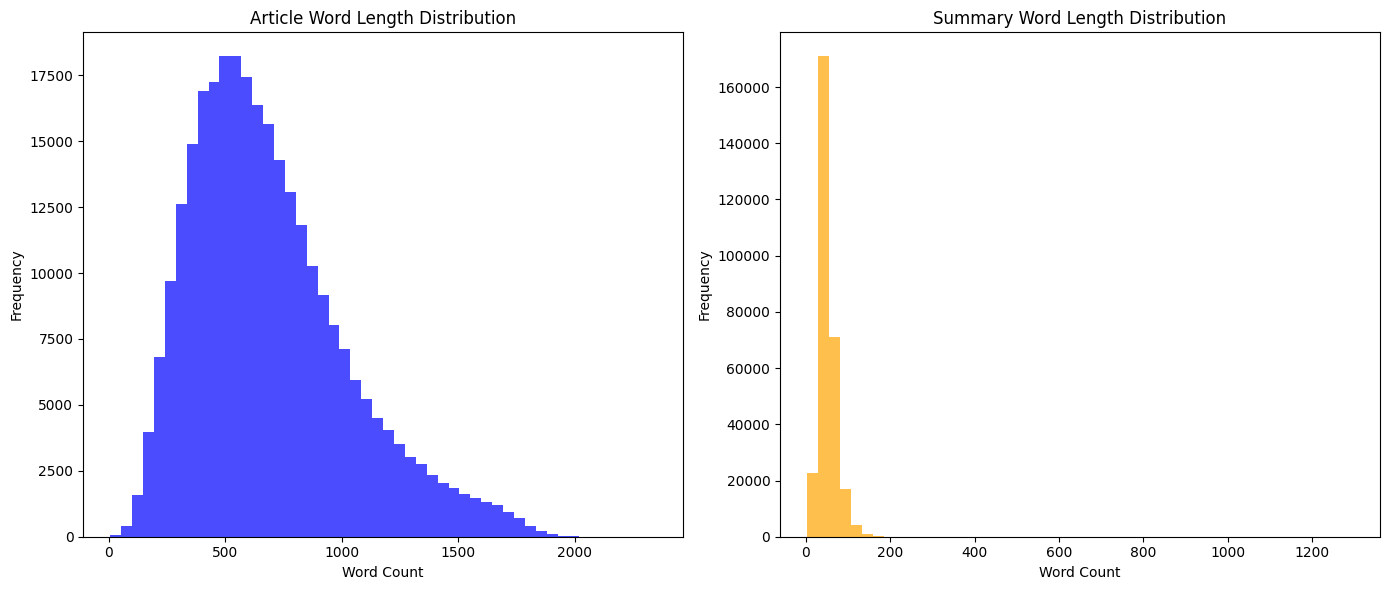

In [47]:
# Compute length (in words) of each article and summary
train_df['article_len'] = train_df['article'].progress_apply(lambda x: len(x.split()))
train_df['summary_len'] = train_df['highlights'].progress_apply(lambda x: len(x.split()))

print("Avg article length (words):", train_df['article_len'].mean())
print("Avg summary length (words):", train_df['summary_len'].mean())
print("Max article length:", train_df['article_len'].max())
print("Max summary length:", train_df['summary_len'].max())
print("Min article length:", train_df['article_len'].min())
print("Min summary length:", train_df['summary_len'].min())


# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

bins = 50  # Number of bins for the histograms; adjust as needed

# Plot histogram for article word lengths
ax1.hist(train_df['article_len'], bins=bins, alpha=0.7, color='blue')
ax1.set_title('Article Word Length Distribution')
ax1.set_xlabel('Word Count')
ax1.set_ylabel('Frequency')

# Plot histogram for summary word lengths
ax2.hist(train_df['summary_len'], bins=bins, alpha=0.7, color='orange')
ax2.set_title('Summary Word Length Distribution')
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Frequency')

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

From the histograms above, we observe that:
- Article lengths vary greatly. Many articles cluster in the within-1000 word range, but there is a tail of longer articles approaching ~1000-1500 words or more. This variance implies our models must handle quite long inputs (and we may consider truncating very long articles due to memory limits). But, there are some articles with extremely short length. These are articles with basically missing content, and we will be removing them from our training set.
- Summary lengths are relatively tight: most summaries are between 40 and 100 words, with a peak around 50 words. Nearly all summaries are just a few sentences. But, there are some summaries that are extremely long. We want out model to generate relatively short summaries so that we can set a reasonable maximum length for generated summaries (e.g., 150 tokens) when configuring our models.

We can also explore if there’s any correlation between article length and summary length:

In [78]:
# Filter the DataFrame to keep only rows where article_len is >= 40
train_df = train_df[train_df['article_len'] >= 40].copy()

# Optionally, reset the index if needed
train_df.reset_index(drop=True, inplace=True)

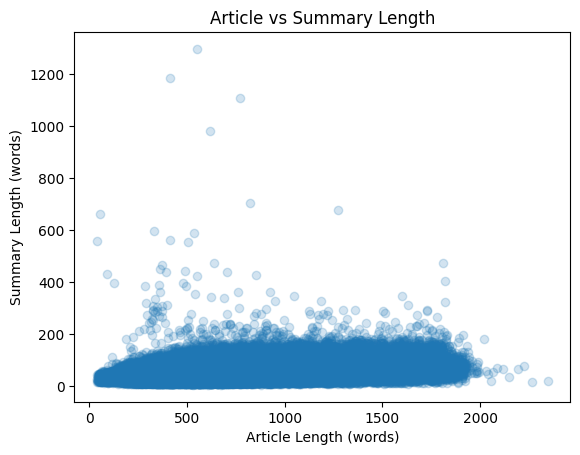

In [79]:
# Scatter plot of article length vs summary length
plt.scatter(train_df['article_len'], train_df['summary_len'], alpha=0.2)
plt.xlabel("Article Length (words)")
plt.ylabel("Summary Length (words)")
plt.title("Article vs Summary Length")
plt.show()

We see almost no correlation. The editors likely write ~3-4 highlight bullet points regardless of article length (though extremely long articles might have slightly longer summaries). Generally, summary length doesn’t increase proportionally with article length in this dataset.

In [32]:
word_counts_article = Counter(" ".join(train_df['article']).split())
word_counts_summary = Counter(" ".join(train_df['highlights']).split())
print("Most common words in articles:", word_counts_article.most_common(10))
print("Most common words in summaries:", word_counts_summary.most_common(10))

Most common words in articles: [('the', 9791244), ('to', 5331980), ('of', 4554135), ('a', 4487087), ('and', 4480666), ('in', 3825206), ('.', 3061087), ('was', 1884598), ('for', 1779834), ('that', 1716986)]
Most common words in summaries: [('.', 1015124), ('the', 444655), ('to', 364393), ('in', 319378), ('of', 286552), ('and', 259113), ('a', 255196), ('for', 141765), ('was', 141272), ('on', 136010)]


#### Feature Engineering